# Distributed Ridge Regression
## Parameter Definition and Centralized Optimization
The problem is defined as

$$
\min_{x \in \mathbb{R}^d} \quad \frac{1}{4} \sum_{i = 1}^4 (u_i^\top x - v_i)^2 + \rho \| x \|^2
$$

where the solution is denoted as $x^*$.

In [1]:
if __name__ == "__main__":
    dim = 10

    # Should be consistent with the definition in the graph server
    n_nodes = 4
    nodes = [str(i) for i in range(1, n_nodes + 1)]

    from numpy import multiply, ones
    from numpy.random import seed, uniform, normal

    seed(0)

    rho = 0.01
    u = {i: uniform(-1, 1, dim) for i in nodes}
    x_tilde = {i: multiply(0.1 * (int(i) - 1), ones(dim)) for i in nodes}
    epsilon = {i: normal(0, 5) for i in nodes}
    v = {i: u[i] @ x_tilde[i] + epsilon[i] for i in nodes}

    import cvxpy as cp

    x = cp.Variable(dim)

    loss = cp.sum([(u[i] @ x - v[i]) ** 2 for i in nodes]) / n_nodes
    regularizer = rho * cp.sum_squares(x)

    prob = cp.Problem(cp.Minimize(loss + regularizer))
    prob.solve(cp.OSQP)

    from numpy import float64
    from numpy.typing import NDArray

    x_star: NDArray[float64] = x.value  # type: ignore

    print(f"Optimal solution: {x_star}")

Optimal solution: [-0.92907018  1.82395728 -2.34861204 -1.14665289 -2.47729986  3.64587729
  2.57938462 -2.66468855 -3.83712911 -0.87901971]


## Benchmarking Distributed Optimization Algorithms

In this section, we benchmark the distributed optimization algorithms `EXTRA`, `NIDS`, `DIGing`, `AugDGM`, `WE`, and `RGT` on the ridge regression problem.
Each algorithm is executed with its respective step size, and their performance is compared in terms of mean squared error (MSE)

$$
\frac{1}{4d} \sum_{i = 1}^{4} || x_i - x^* ||^2
$$

over iterations, where $x_i, x^* \in \mathbb{R}^d$.

The network topology is a ring, and the gossip matrix is defined as $W = I - 0.2L$, with $L$ being the Laplacian matrix of the graph.

In [2]:
from multiprocessing import Pool


def graph() -> None:
    import logging

    logging.basicConfig(level=logging.INFO)

    from numpy import array, eye
    from topolink import Graph

    L = array([[2, -1, 0, -1], [-1, 2, -1, 0], [0, -1, 2, -1], [-1, 0, -1, 2]])
    W = eye(4) - L * 0.2

    graph = Graph.from_mixing_matrix(W)
    graph.deploy()


def ridge_regression(
    node_id: str,
    dimension: int,
    u_i: NDArray[float64],
    v_i: NDArray[float64],
    rho_i: float,
    gamma: float,
    algorithm: str,
) -> NDArray[float64]:
    from numpy import zeros

    max_iter = 2000
    x_i = zeros((max_iter, dimension), dtype=float64)

    # Define loss function
    from dco import LossFunction

    def f(var: NDArray[float64]) -> NDArray[float64]:
        return (u_i @ var - v_i) ** 2 + rho_i * var @ var

    loss_fn = LossFunction(f)

    # Define node handle with masking
    from numpy.random import normal
    from topolink import NodeHandle

    def mask(x: NDArray[float64]) -> NDArray[float64]:
        return x + normal(0, 0.005, x.shape)

    nh = NodeHandle(node_id, mask=mask)

    # Create optimizer and run iterations
    from dco import Optimizer

    optimizer = Optimizer.create(loss_fn, nh, gamma, key=algorithm)

    optimizer.init(x_i[0])

    for k in range(max_iter - 1):
        x_i[k + 1] = optimizer.step(x_i[k])

    return x_i


if __name__ == "__main__":
    step_sizes = {
        "EXTRA": 0.16,
        "NIDS": 0.21,
        "DIGing": 0.11,
        "AugDGM": 0.31,
        "WE": 0.17,
        "RGT": 0.11,
    }

    local_histories: dict[str, list[NDArray[float64]]] = {}

    with Pool(processes=n_nodes + 1) as pool:
        for alg, gam in step_sizes.items():
            tasks = [
                pool.apply_async(
                    ridge_regression, args=(i, dim, u[i], v[i], rho, gam, alg)
                )
                for i in nodes
            ]

            pool.apply(graph)

            local_histories[alg] = [task.get() for task in tasks]

            print(f"Algorithm: {alg}, Step size: {gam}, Finished!")

INFO:topolink.graph:Graph 'default' running on: 172.26.120.171:38681
INFO:topolink.discovery:Registered graph service with name 'default'
INFO:topolink.graph:Node '1' joined graph 'default' from 172.26.120.171:36665.
INFO:topolink.graph:Node '3' joined graph 'default' from 172.26.120.171:43313.
INFO:topolink.graph:Node '2' joined graph 'default' from 172.26.120.171:35737.
INFO:topolink.graph:Node '4' joined graph 'default' from 172.26.120.171:34239.
INFO:topolink.graph:Graph 'default' registration complete.
INFO:topolink.graph:Sent neighbor information to all nodes in graph 'default'.
INFO:topolink.discovery:Unregistered graph service with name 'default'
INFO:topolink.graph:Graph 'default' running on: 172.26.120.171:38063


Algorithm: EXTRA, Step size: 0.16, Finished!


INFO:topolink.discovery:Graph service 'default._topolink._tcp.local.' added
INFO:topolink.discovery:Registered graph service with name 'default'
INFO:topolink.graph:Node '3' joined graph 'default' from 172.26.120.171:40815.
INFO:topolink.graph:Node '2' joined graph 'default' from 172.26.120.171:37433.
INFO:topolink.graph:Node '4' joined graph 'default' from 172.26.120.171:46395.
INFO:topolink.graph:Node '1' joined graph 'default' from 172.26.120.171:36329.
INFO:topolink.graph:Graph 'default' registration complete.
INFO:topolink.graph:Sent neighbor information to all nodes in graph 'default'.
INFO:topolink.node_handle:Node '1' joined graph 'default'.
INFO:topolink.node_handle:Node '1' connected to all neighbors.
INFO:topolink.discovery:Unregistered graph service with name 'default'
INFO:topolink.graph:Graph 'default' running on: 172.26.120.171:43071


Algorithm: NIDS, Step size: 0.21, Finished!


INFO:topolink.discovery:Graph service 'default._topolink._tcp.local.' added
INFO:topolink.discovery:Registered graph service with name 'default'
INFO:topolink.graph:Node '3' joined graph 'default' from 172.26.120.171:36371.
INFO:topolink.graph:Node '2' joined graph 'default' from 172.26.120.171:46229.
INFO:topolink.graph:Node '4' joined graph 'default' from 172.26.120.171:34449.
INFO:topolink.graph:Node '1' joined graph 'default' from 172.26.120.171:41183.
INFO:topolink.graph:Graph 'default' registration complete.
INFO:topolink.graph:Sent neighbor information to all nodes in graph 'default'.
INFO:topolink.node_handle:Node '1' joined graph 'default'.
INFO:topolink.node_handle:Node '1' connected to all neighbors.
INFO:topolink.discovery:Unregistered graph service with name 'default'
INFO:topolink.graph:Graph 'default' running on: 172.26.120.171:41859


Algorithm: DIGing, Step size: 0.11, Finished!


INFO:topolink.discovery:Graph service 'default._topolink._tcp.local.' added
INFO:topolink.discovery:Graph service 'default._topolink._tcp.local.' added
INFO:topolink.discovery:Registered graph service with name 'default'
INFO:topolink.graph:Node '3' joined graph 'default' from 172.26.120.171:44871.
INFO:topolink.graph:Node '4' joined graph 'default' from 172.26.120.171:39051.
INFO:topolink.graph:Node '1' joined graph 'default' from 172.26.120.171:43865.
INFO:topolink.graph:Node '2' joined graph 'default' from 172.26.120.171:35971.
INFO:topolink.graph:Graph 'default' registration complete.
INFO:topolink.graph:Sent neighbor information to all nodes in graph 'default'.
INFO:topolink.node_handle:Node '1' joined graph 'default'.
INFO:topolink.node_handle:Node '2' joined graph 'default'.
INFO:topolink.node_handle:Node '2' connected to all neighbors.
INFO:topolink.node_handle:Node '1' connected to all neighbors.
INFO:topolink.discovery:Unregistered graph service with name 'default'
INFO:topol

Algorithm: AugDGM, Step size: 0.31, Finished!


INFO:topolink.discovery:Graph service 'default._topolink._tcp.local.' added
INFO:topolink.discovery:Graph service 'default._topolink._tcp.local.' added
INFO:topolink.discovery:Registered graph service with name 'default'
INFO:topolink.graph:Node '2' joined graph 'default' from 172.26.120.171:40727.
INFO:topolink.graph:Node '3' joined graph 'default' from 172.26.120.171:46733.
INFO:topolink.graph:Node '1' joined graph 'default' from 172.26.120.171:42659.
INFO:topolink.graph:Node '4' joined graph 'default' from 172.26.120.171:39109.
INFO:topolink.graph:Graph 'default' registration complete.
INFO:topolink.graph:Sent neighbor information to all nodes in graph 'default'.
INFO:topolink.node_handle:Node '1' joined graph 'default'.
INFO:topolink.node_handle:Node '4' joined graph 'default'.
INFO:topolink.node_handle:Node '1' connected to all neighbors.
INFO:topolink.node_handle:Node '4' connected to all neighbors.
INFO:topolink.discovery:Unregistered graph service with name 'default'
INFO:topol

Algorithm: WE, Step size: 0.17, Finished!


INFO:topolink.discovery:Graph service 'default._topolink._tcp.local.' added
INFO:topolink.discovery:Graph service 'default._topolink._tcp.local.' added
INFO:topolink.discovery:Graph service 'default._topolink._tcp.local.' added
INFO:topolink.discovery:Registered graph service with name 'default'
INFO:topolink.graph:Node '4' joined graph 'default' from 172.26.120.171:38437.
INFO:topolink.graph:Node '2' joined graph 'default' from 172.26.120.171:32875.
INFO:topolink.graph:Node '1' joined graph 'default' from 172.26.120.171:40605.
INFO:topolink.graph:Node '3' joined graph 'default' from 172.26.120.171:41129.
INFO:topolink.graph:Graph 'default' registration complete.
INFO:topolink.graph:Sent neighbor information to all nodes in graph 'default'.
INFO:topolink.node_handle:Node '3' joined graph 'default'.
INFO:topolink.node_handle:Node '1' joined graph 'default'.
INFO:topolink.node_handle:Node '2' joined graph 'default'.
INFO:topolink.node_handle:Node '1' connected to all neighbors.
INFO:topo

Algorithm: RGT, Step size: 0.11, Finished!


## Plot results

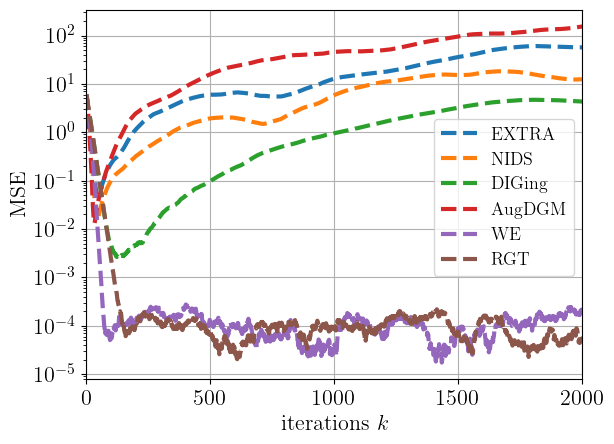

In [3]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    from numpy import mean, stack

    plt.rcParams["text.usetex"] = True
    plt.rcParams["font.family"] = "serif"

    plt.rcParams.update(
        {
            "font.size": 14,
            "axes.titlesize": 16,
            "axes.labelsize": 16,
            "xtick.labelsize": 16,
            "ytick.labelsize": 16,
            "legend.fontsize": 13,
        }
    )

    fig, ax = plt.subplots()

    line_options = {"linewidth": 3, "linestyle": "--"}

    hh: list[NDArray[float64]] = []

    for algorithm, histories in local_histories.items():
        # shape: (n_nodes, n_iter, dim)
        stacked_histories = stack(histories)
        # shape: (n_nodes, n_iter)
        mse_evolution_nodes = mean((stacked_histories - x_star) ** 2, axis=2)
        mse_evolution = mean(mse_evolution_nodes, axis=0)
        ax.semilogy(mse_evolution, label=algorithm, **line_options)
        hh.append(mse_evolution)

    ax.set_xlim((0, 2000))
    ax.set_xlabel("iterations $k$")
    ax.set_ylabel("MSE")
    ax.legend(loc=(0.7, 0.28))
    ax.grid(True, which="major", linestyle="-", linewidth=0.8)